## Question 1: Anxious Accountant

Assume that there are $N$ chain stores that are located at different places, labeled $1, 2, \ldots, N$; let $x_1,\ldots, x_N$ denote the locations. The total cost of transporting goods across all the stores every month is defined as
$$O = \sum_{i\neq j} f_{ij} d(x_i, x_j),$$
where $f_{ij}$ is the flow between store $i$ and store $j$. The store locations are designed such that the flow between store $i$ and store $j$ is inversely proportional to the distances between store $i$ and store $j$, i.e.
$$f_{ij} \propto 1/ d(x_i, x_j),$$
where $d(x_i, x_j)$ is the Euclidean distance between stores $i$ and $j$. Therefore the total cost of transporting goods is $O=\sum_{i\neq j} 1 = N(N-1)$, which results in a constant budget for transporting goods across stores every month. However, the careless accountant lost track of the labels of the stores, he is worried about being fired and thus decided not to tell the boss about this. His strategy is to randomly label the stores and use $f_{ij}$ as the flow between stores $i$ and $j$ in his labeling. Given a random permutation $\delta(\cdot)$ of the labels of the stores, the total cost becomes:
$$O = \sum_{i\neq j} f_{ij} d(x_{\delta(i)}, x_{\delta(j)}).$$
However, a simple calculation tells him that under many permutations, the total cost for transportation can be so large that a much higher budget for transportation is needed. How can the boss not discover such a sudden increase of the budget? Assume that the accountant comes to you and asks you to design a permutation such that the total cost is as small as possible, ideally to recover the true labels. You decide to try and help him using simulated annealing. 

Now, you want to use some simulation studies to see if you can help him figure out the problem.

(1) Assume that $N=5$, the stores are located on a real line.

(2) Assume that $N=10$, the stores are located on a two-dimensional space.

(3) Assume that $N=10$, the stores are located on the three-dimensional space.

In each of the scenarios above, how hard do you find it to figure out the correct solution, or a solution that is close?

Hint: here is the simulation set-up.
1. simulate N locations $x_1,\ldots, x_N$ in $\mathbb{R}^d$ where $d=1,2,3$ in (1), (2), (3);
2. simulate a 'true permutation' $\delta_{true}$, e.g. $2,4,1,3,0,5$ when $N=6$;
3. calculate the matrix for the flow $F=[f_{ij}]$ as follows: permuate the locations $(x_1,\ldots, x_N)$ according to $\delta_{true}$ and calculate the pairwise distance of the permuted locations, taking element-wise inverse of this distance matrix gives $F$;
4. assume that you do not know the true permutation $\delta_{true}$, taking $(x_1,\ldots, x_N)$ and $F$ as input, try to find the permuation that minimizes the cost. 

[A simpler simulation: Note that if you do not simulate a true permutation and instead directly calculate the pairwise distance and flow matrix, the true permutation is actually the identity.]

Optional: To get a better feel for simulated annealing, increase N and play a bit around with different parameters. What are your observations? 

### Solution

In [11]:
import numpy as np
import scipy
from scipy import spatial
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import time

In [2]:
# Computes and returns a matrix of the euclidean distances between each pair of the given locations
def calculate_pairwise_dist(location):
    condensed_pairwise_dist = scipy.spatial.distance.pdist(location, 'euclidean')
    D = scipy.spatial.distance.squareform(condensed_pairwise_dist)
    return D

# Computes our objective function, given a permutation of the locations
def objective_func(location_new, F):
    return np.sum(calculate_pairwise_dist(location_new) * F)

# Performs L consecutive permutations on a given input permutation
def change_perm(input_perm, L):
    total = len(input_perm)
    q = input_perm.copy()
    for i in xrange(L):
        c1, c2 = np.random.choice(total, 2, replace=False)
        temp = q[c1].copy()
        q[c1] = q[c2].copy()
        q[c2] = temp
    return q

def SA_assign(locations, F, Niter, reannealing, thermostat, temperature_init, low_temp):
    
    N = locations.shape[0]
    temperature = temperature_init
    # Set initial permutation and reset the variables
    perm_old = np.random.permutation(range(N))
    Objective_old = objective_func(locations[perm_old,:], F)
    Objective_hist = []
    opt_obj = np.inf
    opt_perm = perm_old

    for iter in range(Niter):
        # Set the number of permutation steps to 1+sqrt(temperature), to reduce auto-correlation
        L = 1 + np.floor(np.sqrt(temperature)).astype(int)
        perm_new = change_perm(perm_old, L)
        Objective_new = objective_func(locations[perm_new, :], F)
        
        diff = - Objective_new + Objective_old

        if np.log(np.random.rand()) < diff/temperature:
            perm_old = perm_new.copy()
            Objective_old = Objective_new
            # save best encountered result
            if Objective_old < opt_obj:
                opt_obj = Objective_old
                opt_perm = perm_old.copy()

        # Reduce the temperature every reannealing iterations, but not beyond low_temp
        if (iter % reannealing == 0 and temperature > low_temp):
            temperature = thermostat * temperature
            
        Objective_hist.append(Objective_old)
    
    plt.figure()
    plt.plot(Objective_hist)
    plt.grid()
    plt.title("Objective function")

    return perm_old, Objective_old, opt_perm, opt_obj


#### (1) N = 5, stores are located on a real line

Optimal permutation: [3 2 0 1 4], with an optimal cost: 20.0
SA best result: [3 2 0 1 4], with a cost: 20.0


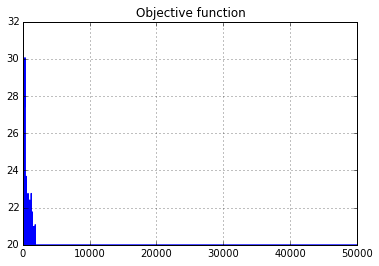

In [7]:
N = 5
d = 1
locations = 10.0 * np.random.random([N, d])
perm_set = np.random.permutation(range(N))
A = np.array([[0 for i in range(N)] for j in range(N)])
A[range(N), range(N)] = 1.0
F = 1.0 / (calculate_pairwise_dist(locations[perm_set,:]) + A)
F[range(N), range(N)] = 0.0
D = calculate_pairwise_dist(locations[perm_set,:])

Niter = 50000
temperature_init = 2.0
reannealing = 100
thermostat = 0.9
low_temp = 0.0
_, _, SA_result, SA_result_cost = SA_assign(locations, F, Niter, reannealing, thermostat, temperature_init, low_temp)

print "Optimal permutation: {}, with an optimal cost: {}".format(perm_set, np.sum(D * F))
print "SA best result: {}, with a cost: {}".format(SA_result, SA_result_cost)


#### (2) N = 10, stores are located on a two dimensional space

Optimal permutation: [4 0 5 9 8 2 1 3 6 7], with an optimal cost: 90.0
SA best result: [4 0 5 9 8 2 1 3 6 7], with a cost: 90.0


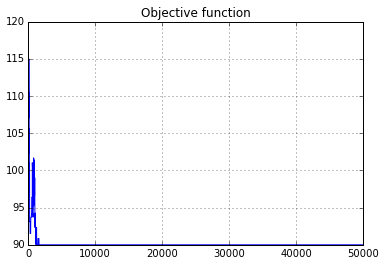

In [8]:
N = 10
d = 2
locations = 10.0 * np.random.random([N, d])
perm_set = np.random.permutation(range(N))
A = np.array([[0 for i in range(N)] for j in range(N)])
A[range(N), range(N)] = 1.0
F = 1.0 / (calculate_pairwise_dist(locations[perm_set,:]) + A)
F[range(N), range(N)] = 0.0
D = calculate_pairwise_dist(locations[perm_set,:])

Niter = 50000
temperature_init = 2.0
reannealing = 100
thermostat = 0.9
low_temp = 0.0
_, _, SA_result, SA_result_cost = SA_assign(locations, F, Niter, reannealing, thermostat, temperature_init, low_temp)

print "Optimal permutation: {}, with an optimal cost: {}".format(perm_set, np.sum(D * F))
print "SA best result: {}, with a cost: {}".format(SA_result, SA_result_cost)

#### (3) N = 10, stores are located on a three dimensional space

Optimal permutation: [8 7 2 5 4 1 3 6 9 0], with an optimal cost: 90.0
SA best result: [8 7 2 5 4 1 3 6 9 0], with a cost: 90.0


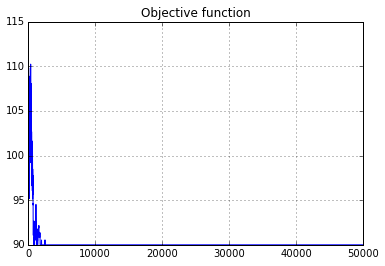

In [9]:
N = 10
d = 3
locations = 10.0 * np.random.random([N, d])
perm_set = np.random.permutation(range(N))
A = np.array([[0 for i in range(N)] for j in range(N)])
A[range(N), range(N)] = 1.0
F = 1.0 / (calculate_pairwise_dist(locations[perm_set,:]) + A)
F[range(N), range(N)] = 0.0
D = calculate_pairwise_dist(locations[perm_set,:])

Niter = 50000
temperature_init = 2.0
reannealing = 100
thermostat = 0.9
low_temp = 0.0
_, _, SA_result, SA_result_cost = SA_assign(locations, F, Niter, reannealing, thermostat, temperature_init, low_temp)

print "Optimal permutation: {}, with an optimal cost: {}".format(perm_set, np.sum(D * F))
print "SA best result: {}, with a cost: {}".format(SA_result, SA_result_cost)

It turned out finding the right permutation is actually not hard at all for so small $N$. All three settings converge with the same parameter values. If you did the optional part you might have observed that using a larger $N$ makes the problem harder and you need to tune the parameters more carefully. 

It is important to tune the initial temperature to not have the beginning of the objective function jump too much between values. What we are looking for is a nice drop after a few iterations. 

## Question 2: Busy  Bond

M assigns James Bond a secret mission to help save a very important person. To protect the person, M sends James Bond three noisy images of the person's name through different channels. James Bond decides to recover the secret  person's name by statistical inference so he comes to you for help. 

You can find the three noisy images as $35 \times 105$ binary matrices with values 0 and 1 in the files "secret_1.csv", "secret_2.csv", and "secret_3.csv". Suppose $Y^{(k)}$ represents the matrix of the noisy image number $k$, and $X$ represents the matrix of the real image you want to recover. $X_i$ and $Y_i^{(k)}$ is the value of the $i$th pixel. 

To solve the problem in a more statistical way, you  model $X$ with the following distribution (inspired by the Ising model):

$$\pi(X|Y) \propto \exp(\sum_{i,k}  I[X_i=Y_i^{(k)}] + \beta \sum_{j\sim i}  I[X_i=X_j]).$$

Here, $j\sim i$ means the $j$th pixel is in the neighborhood of the $i$th pixel and the neighborhood is defined as the 8 vertical, horizontal and diagonal adjacencies of each pixel.

(a) Use a Metropolis-Hasting algorithm to sample from $\pi(X|Y)$ and recover the image by averaging samples from the distribution. How would you choose the proposal distribution? Try different values for $0 < \beta < 1.0$ and how they influence the result. Pick the one that you like best and give a short comment why. Please write down the details of the algorithm and run it. 

(b) To impress James Bond, you decide to also implement parallel tempering to solve the problem. Please explain and comment your implementation and run the algorithm. How does your parallel tempering implementation compare to standard Metropolis-Hastings? Commment on your choices for the number of chains and temperatures. 

(c) Who is the important person? Please help James Bond save the world!

## Solution:
First, we plot the three pictures to have a brief idea of the problem. We average the three pictures and plot the result, which produces a less noisy picture. The person might be "Harry Potter".

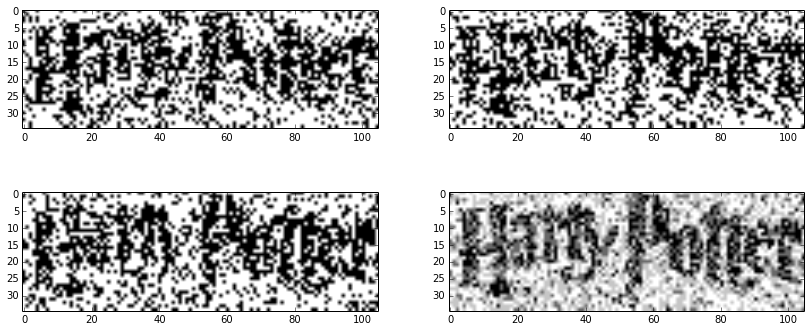

In [7]:
plt.figure(figsize=(14,6))
Y1 = pd.read_csv("secret_1.csv", header=None).values
plt.subplot(221)
plt.imshow(Y1, cmap=cm.Greys_r)
Y2 = pd.read_csv("secret_2.csv", header=None).values
plt.subplot(222)
plt.imshow(Y2, cmap=cm.Greys_r)
Y3 = pd.read_csv("secret_3.csv", header=None).values
plt.subplot(223)
plt.imshow(Y3, cmap=cm.Greys_r)
Y = (Y1+Y2+Y3)/3.0
plt.subplot(224)
plt.imshow(Y, cmap=cm.Greys_r)
plt.show()

(a) Now, we work with the Metropolis-Hastings method to sample the real image $X$. First we define function to count the number of neighbors of each pixel with values 1 or 0.

In [8]:
def neighbor(X,i,j):
    neigh = []
    sum = 0
    count = 0
    # Sum up all possible neighbors
    if i>0:
        sum += X[i-1,j]
        count += 1
    if i<34:
        sum += X[i+1,j]
        count += 1
    if j>0:
        sum += X[i,j-1]
        count += 1
    if j<104:
        sum += X[i,j+1]
        count += 1
    if i>0 and j>0:
        sum += X[i-1,j-1]
        count += 1
    if i>0 and j<104:
        sum += X[i-1,j+1]
        count += 1
    if i<34 and j>0:
        sum += X[i+1,j-1]
        count += 1
    if i<34 and j<104:
        sum += X[i+1,j+1]
        count += 1
    
    return sum, count-sum

The proposal distribution is defined as follows. We start with one of the noisy images as our initial image, and then for each step of the MH, we randomly choose a pixel and flip the value of the pixel. That is to say we chang 1 to 0 and 0 to one. And then decide if we accept the flip or not, based on the change of the energy function produced by that single flip.

In [9]:
# a function to compute the change of probability for flip in X_{i,j}.
# t is defined as the temperature.
def logp_vsk(X,Y1,Y2,Y3,i,j,t):
    sp1, sp0 = neighbor(X, i, j)
    # The 2.0 is because for each pair (X_i, X_j), we compute it twice.
    p1 = alpha*(Y1[i,j] + Y2[i,j]+ Y3[i,j])+2.0*beta*sp1
    p0 = alpha*(1-Y1[i,j] + 1-Y2[i,j] + 1-Y3[i,j]) + 2.0*beta*sp0
    diff = (p1-p0)*(1-2*X[i,j])/t
    
    return diff

def mcmc_vsk(X0, Y1,Y2, Y3, N,t):
    X = np.zeros((35, 105)).astype(float)
    Xtemp = X0.copy()
    r = np.random.random(N)
    I = np.random.choice(35,size=N)
    J = np.random.choice(105,size=N)
    for k in xrange(N):
        i = I[k]
        j = J[k]
        if np.log(r[k]) < logp_vsk(Xtemp,Y1, Y2,Y3,i,j,t):
            Xtemp[i,j] = 1 - Xtemp[i,j]
        X = X + Xtemp.copy()
            
    return X, Xtemp.copy()

We could choose different $\beta$ to recover the image $X$. The higher the value of $\beta$, the more the algorithm will attempt the image to be uniform, in the sense that it will try to make neighboring pixels of the same color. This is good for reduciong the noise, but a value of $\beta$ that is too big will smooth the image too much, making the characters difficult to read. A good value for this parameter is about $\beta = 0.2$.

Time for perform MH with 100000 samples is 3.980791.


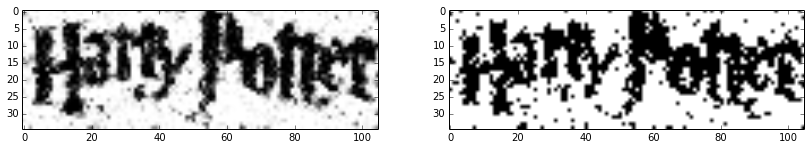

In [12]:
start_time = time.clock()
alpha = 1.0
beta = 0.20
# More samples are encouraged for more precise computation.
N = 100000
X0 = Y1.copy()
t = 1
X, X_tmp = mcmc_vsk(X0, Y1, Y2,Y3, N, t) 
X = X/X.max()

plt.figure(figsize=(14,3))
# Show the average image
plt.subplot(121)
plt.imshow(X, cmap=cm.Greys_r)
# Show the last image of the iteration
plt.subplot(122)
plt.imshow(X_tmp, cmap=cm.Greys_r)

print "Time for perform MH with "+str(N)+" samples is "+str(time.clock() - start_time)+"."

(b) To impress Bond, we perform a parallel tempering method. First, we define a function to calculate the $\log(\pi(X|Y))$.

In [13]:
def ind(X1, X2):
    return (1-(X1-X2)**2).sum()
def logprob(X, Y):
    # 2.0 is because we compute each pair (X_i, X_j) twice.
    prob = alpha*ind(X,Y) + 2.*beta*(ind(X[:34,:],X[1:,:])+ind(X[:,1:],X[:,:104])+ind(X[:34,:104],X[1:,1:])+ind(X[1:,:104],X[:34,1:]))
    return prob

Now, we define a parallel tempering method for sampling. Please note that this is a serial version of parallel tempering.

In [14]:
# pswap is the probability for swap, M is the number of temperature and Temp is all the temperatures.
def parallel(X0, Y, N, M, Temp,pswap):
    X = np.zeros((35, 105)).astype(float)
    Xtemp = np.zeros((M, 35, 105)).astype(float)
    for i in xrange(M):
        Xtemp[i,:,:] = X0.copy()
        
    r = np.random.random(N*M).reshape((M, N))
    I = np.random.choice(35,size=N*M).reshape((M,N))
    J = np.random.choice(105,size=N*M).reshape((M,N))
    # Find the position to swap
    swap = np.random.binomial(n=1,p=pswap,size=N)
    # We don't swap for the first step.
    swap[0] = 0
    index = np.linspace(0,N-1,N).astype(int)
    swapIndex = index[swap==1]
    
    for k in xrange(len(swapIndex)-1):
        #print swapIndex
        # Run the Metropolis-Hasting between each swap for every temperature.
        for t in xrange(M):
            #print Temp[t]
            Xsum, Xtemp[t,:,:] = mcmc_vsk(Xtemp[t,:,:], Y1, Y2, Y3, swapIndex[k+1]-swapIndex[k], Temp[t])
            if t == 0:
                X += Xsum.copy()
                
        index = np.random.choice(M, 2, replace=False)
        X -= Xtemp[0,:,:].copy()
        diffp = (logprob(Xtemp[index[1],:,:],Y) - logprob(Xtemp[index[0],:,:],Y))*(1.0/Temp[index[0]] - 1.0/Temp[index[1]])
        
        # Decide whether to swap the chain or not.
        if np.log(np.random.random(1)) < diffp:
            temp = Xtemp[index[0],:,:].copy()
            Xtemp[index[0],:,:] = Xtemp[index[1],:,:].copy()
            Xtemp[index[1],:,:] = temp.copy()
        X += Xtemp[0,:,:].copy()
        
    Xsum, Xtemp[0,:,:] = mcmc_vsk(Xtemp[0,:,:], Y1, Y2, Y3, N-index[len(index)-1], Temp[0])
    X += Xsum
    
    return X, Xtemp[0,:,:].copy()

We use four walkers with temperatures of 1.0, 1.2, 1.4, 1.6. In general, temperatures that are too large will tend to accept too few porposed steps, making teh convergence very slow. We only keep record of the walker with temperature of 1.0. We plot the result of averaging 50000 samples.

Time for perform parallel tempering with 50000 samples is 10.359933.


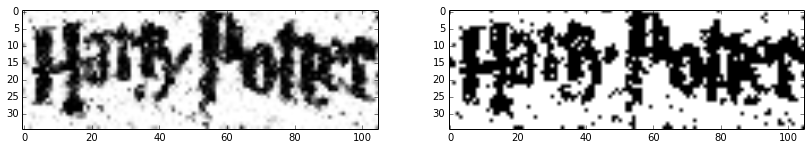

In [15]:
start_time = time.clock()
alpha = 1.0
beta = 0.2
N = 50000
M = 4
Temp = [1.0,1.2,1.4,1.6]
pswap = 0.01
X0 = Y1.copy()
X, X_tmp = parallel(X0, Y, N, M, Temp,pswap)
X = X/X.max()

plt.figure(figsize=(14,3))
# Show the average image
plt.subplot(121)
plt.imshow(X, cmap=cm.Greys_r)
# Show the last image of the iteration
plt.subplot(122)
plt.imshow(X_tmp, cmap=cm.Greys_r)

print "Time for perform parallel tempering with "+str(N)+" samples is "+str(time.clock() - start_time)+"."

(c) The important person in Harry Potter.